# Estudo da Rede de Coocorrência de Playlists do Spotify 🎵 🎶

# Introdução

Nesse notebook, estaremos realizando um estudo da rede de coocorrência formada por artistas presentes em playlists do Spotify, utilizando como base dados fornecidos em 2018 pelo próprio [Spotify no The Spotify Million Playlist Dataset Challenge.](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge)

Esse dataset (Conjunto de dados) disponibilizava dados de um milhão de playlists, criadas por usuários, para que fossem desenvolvidos modelos de machine learning capazes de completar as playlists de forma automática

No nosso caso, os dados foram utilizados para criar uma rede que tem como nós os artistas presentes nas playlists e as arestas são criadas observando quais artistas estão presentes na mesma playlist.

Por exemplo, imagine uma playlist com os seguintes artistas:
 - Anitta
 - Anitta
 - Alok
 - Justin Bieber

Essa playlist formaria o seguinte grafo:
   
![img](https://miro.medium.com/max/487/1*h2pVRe5223i7blf1FCL60w.png)

Desse modo foi gerado o grafo utilizando uma parte do dataset (Com apenas 500 artistas) fornecido com o objetivo de realizar análises sobre a disposição da rede através de grandezas conhecidas, criando gráficos e exibindo os nós com valores mais importantes.

As métricas utilizadas para análise foram:
 - Métricas Globais:
  - Eccentriciy 
  - Periphery
  - Radius
  - Center
 - Node ranking:
  - Degree Centrality 
  - Closeness Centrality
  - Betweenness Centrality
  - EigenVector Centrality
 - Análise Bivariada (PDF e CDF)
 - Análise Multivariada
 - Análise de decomposição da rede

# Preparando Grafo

### Preparando Ambiente

In [ ]:
# Instalando nxviz
!pip install nxviz==0.6.3

In [ ]:
# imports
import networkx as nx
import nxviz
from nxviz.plots import CircosPlot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas as pd


### Importando Grafo

In [ ]:
G = nx.read_graphml('spotfy.graphml')

### Verificando disposição do grafo para análises posteriores

In [ ]:
# Verifica se o grafo é conectado
nx.is_connected(G)

False

Como o grafo não é conectado devemos observar quais são os componentes conectados para trabalharmos com o melhor componente

In [ ]:
# Imprime quais são os nós que compoem os componentes conectados
lista_componentes_conectados = []
print("Tamanho do componente conectado:")
contador =0
for i in nx.connected_components(G):
  contador += 1
  lista_componentes_conectados.append(i)
  print(str(contador)+"º -",len(i))

Tamanho do componente conectado:
1º - 9697
2º - 3
3º - 3
4º - 7
5º - 12


Aparentemente apenas o apenas o primeiro componente apresenta dados que serão interessantes para a nossa análise, já que os outros, pela forma que as nossa rede foi montada, provavelmente estão em apenas uma playlist, já que não tem conexão com os outros artistas mais famosos.

In [ ]:
# Pegando para criação de grafos somente o maior componente conectado subgrafo 
G_1 = G.subgraph(lista_componentes_conectados[0])

### FIltrando grafo para diminuir complexidade e custo das análises

Para tornar a análise possível foi necessário filtrar os dados, deixando apenas os artistas que possuem maior relevancia na rede, para isso foi utilizado o grau de cada artista, levando em consideração os pesos dos nós.

In [ ]:
# Pegando artistas com maior Grau e salvando em lista
lista_pesos = [[peso[1],peso[0]] for peso in list(G_1.degree(weight='weight'))]
lista_pesos.sort(reverse=True)

# Pegando lista somente com nomes de artistas na ordem de maior grau para o menor
lista_artistas = [artista for grau,artista in lista_pesos]

In [ ]:
# 10 artistas com maiores graus na rede
lista_artistas[:10]

['Drake',
 'Kanye West',
 'Kendrick Lamar',
 'Rihanna',
 'Eminem',
 'Future',
 'Lil Uzi Vert',
 'Chris Brown',
 'The Weeknd',
 'Twenty One Pilots']

Criando um novo subgrafo contendo apenas os 500 artistas mais relevantes na rede.

In [ ]:
# Pega subgraph com apenas os 500 artistas com maior peso, a quantidade pode ser modificada caso queira trabalhar com mais nós
quantidade_artistas = 500
subgraph = G_1.subgraph(lista_artistas[:quantidade_artistas])
nx.write_graphml(subgraph, 'spotfy500.graphml')

# Troca nome problemático de um dos nodes
mapping = {'Joey Bada$$':'Joey BadaSS'}
subgraph = nx.relabel_nodes(subgraph, mapping)

# Métricas Globais

## Definições Básicas - Eccentriciy, Periphery, Radius, Center

### Eccentriciy 

A métrica de eccentriciy (Excentricidade) diz respeito a quão "excêntrico" , isto é, distante do centro, um determinado nó é. Para isso, para cada nó, são calculadas as menores distâncias dele para todos os outros nós da rede. A maior dessas menores distâncias é o valor da excentricidade desse nó, quanto maior esse valor mais "excêntrico" esse nó é.

Ao gerar o gráfico da excentricidade dos nós da rede analisada, através do código abaixo, obtivemos:

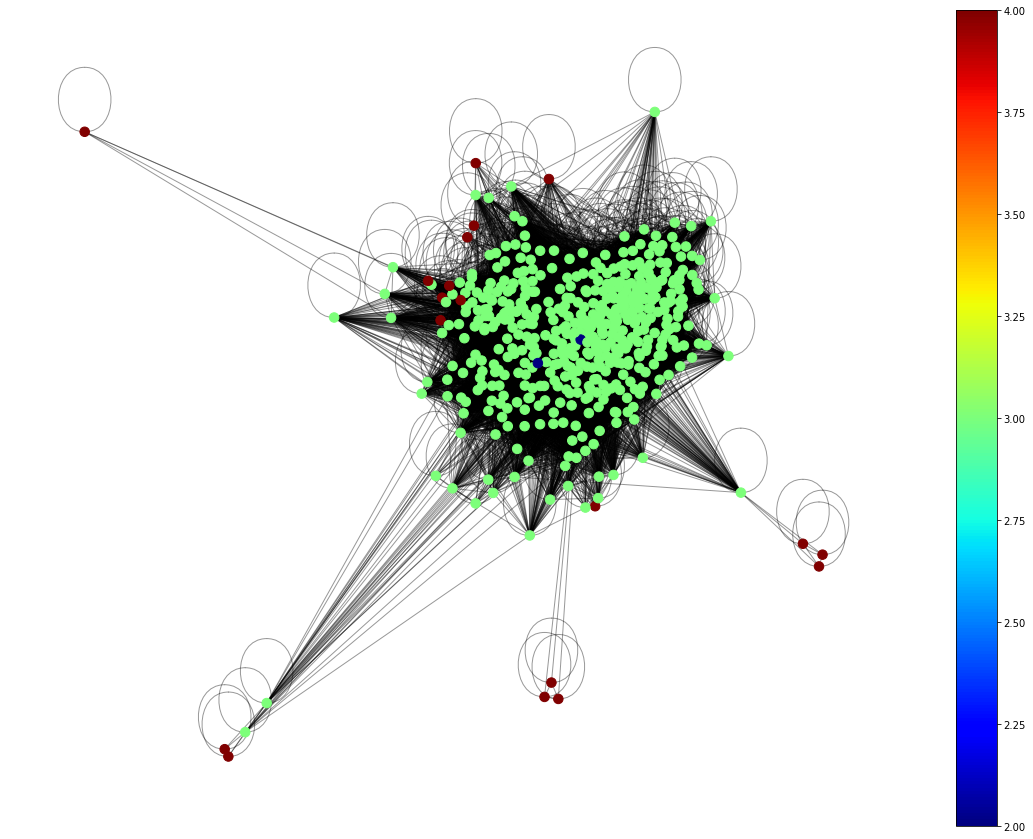

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes based on eccentricity
color = list(dict(nx.eccentricity(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eccentricity.png', transparent=True,dpi=300)
plt.show()



Como foram pegos apenas os 500 nós (artistas) com maior grau da rede, a figura apresenta apenas três graus de ecentricity, mostrando que a grande maioria dos nós estão conectados entre si, e por isso não apresentam grande variação de distância máxima.

Podemos perceber também que a maior parte dos nós possui excentricidade igual a 3, outra parte possui valor 4 e outra pequena parte possui valor 2. Logo, temos que a rede possui 3 níveis de excentricidade.

### Diameter

O parâmetro diameter refere-se ao diâmetro da rede. Na análise de redes, o diâmetro de uma rede corresponde ao maior valor de excentricidade que a rede possui.

O código abaixo nos dá algumas informações sobre o diâmetro


In [ ]:
# Pegando o diametro da rede
max_eccentricity = nx.diameter(subgraph)


print("Diametro da rede: {}".format(max_eccentricity))

# Níveis de excentricity da rede

print("Quais os níveis de excentricity da rede: ",set([v for k,v in nx.eccentricity(subgraph).items()]))

# Quem está no diametro
print("Quem ocupa o diametro da rede: ",[k for k,v in nx.eccentricity(subgraph).items() if v == max_eccentricity])

Diametro da rede: 4
Quais os níveis de excentricity da rede:  {2, 3, 4}
Quem ocupa o diametro da rede:  ['Gary Allan', 'Original Broadway Cast Recording', 'Matilda the Musical Original Cast', 'Hadag Nahash', 'Bullet For My Valentine', 'Conditions', 'Tzvi Silberstein', 'Josh Abbott Band', 'Tribal Seeds', 'Stephen Sondheim', 'Iron Chic', 'The Walkmen', 'Pepper', 'The Orwells', 'Ari Goldwag', 'Coheed and Cambria', 'Jon Wolfe', 'Cody Johnson', 'Jimmy Needham']


### Periphery 

Periphery (Periferia) são os nós que ocupam as "bordas" da rede. Tal métrica possui uma relação íntima com diâmetro da rede, pois, na prática, a periferia é o conjunto de nós cuja excentricidade é igual ao valor do diâmetro da rede (No caso da nossa rede, os nós que possuem excentricidade igual a 4).

Ao utilizar a função `periphery()` do networkX passando o nosso grafo como argumento obteremos uma lista com os nós que fazem parte da periferia da rede.

In [ ]:
# Mostra Periphery
nx.periphery(subgraph)

['Gary Allan',
 'Original Broadway Cast Recording',
 'Matilda the Musical Original Cast',
 'Hadag Nahash',
 'Bullet For My Valentine',
 'Conditions',
 'Tzvi Silberstein',
 'Josh Abbott Band',
 'Tribal Seeds',
 'Stephen Sondheim',
 'Iron Chic',
 'The Walkmen',
 'Pepper',
 'The Orwells',
 'Ari Goldwag',
 'Coheed and Cambria',
 'Jon Wolfe',
 'Cody Johnson',
 'Jimmy Needham']

### Radius

Assim como o diâmetro, uma rede também possui o atributo referente ao raio (radius) da rede. No contexto das redes, o raio refere-se ao menor valor da excentricidade da rede (No caso da nossa rede, o valor 2).

O networkX também oferece um método para retornar o valor do raio da rede. Tal método é o `radius()` que recebe um grafo como argumento.

In [ ]:
# pega a menor eccentricity da rede
raio = nx.radius(subgraph)
print("Radius of network(g): {}".format(raio))
print([k for k,v in nx.eccentricity(subgraph).items() if v == raio])

Radius of network(g): 2
['Justin Bieber', 'The Killers']


### Center

Diferente da periferia, o center refere-se ao conjunto de nós cujo valor da excentricidade é igual ao do raio da rede, isto é, que estão no centro do grafo. 

Assim como na periferia, o networkX oferece o método `center()` que recebe um grafo como argumento e retorna a lista de nós que estão no centro do grafo, que no caso da nossa rede a saída gerada é `['Justin Bieber','The Killers']`.

In [ ]:
# imprime nós do center
nx.center(subgraph)

['Justin Bieber', 'The Killers']

## Resultado
Como podemos perceber, existem poucos nodes (nós) ocupando o centro e o diâmetro da rede, a maioria dos nós está entre eles, com valor de eccentricity 3.

Isso se deve ao fato de que a maioria dos nós tem conexões diretas entre si, o que faz com que a sua distância máxima para os outros nós seja sempre bem baixa e uniforme.

# Node ranking

Foram analisadas também algumas métricas referentes ao Node Ranking, isto é, o ranqueamento dos nós. Através dessas métricas de ranqueamento podemos definir a importância de um nó para a rede.

### Degree Centrality

Antes de falarmos da métrica degree centrality, é interessante o conhecimento sobre o degree (grau) de um nó.

O grau de um nó, nada mais é do que a quantidade nós vizinhos que um nó tem. Por exemplo, levando em consideração a figura de exemplo de grafo (Aquela que mostra um grafo com Annita, Alok e Justin Bieber) temos que o grau do nó referente ao Alok é 3, pois ele possui os 2 nós da Annita e 1 nó do Justin Bieber como vizinhos.

O código a seguir gera um gráfico que mostra a relação dos nós da rede analisada com seus graus:

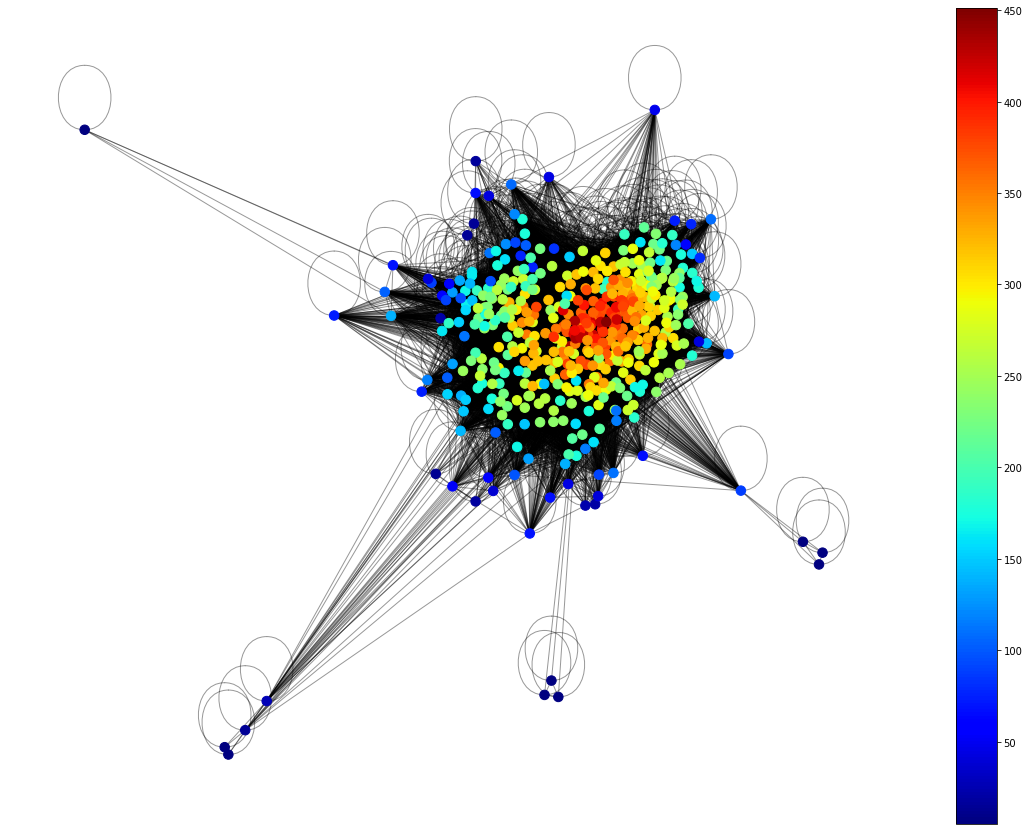

In [ ]:
# the degree of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree.png', transparent=True,dpi=300)
plt.show()

Pela leitura da legenda e do gráfico, percebemos que existem nós de graus variados. Alguns com um valor menor que cem (azuis escuros), outros na faixa entre 100 e 200 (Um azul mais claro) e assim por diante, sendo os nós vermelhos os que possuem os maiores graus da rede (entre 400 e 450).

O degree centrality, por sua vez, trata-se do grau de um nó dividido pelo número máximo de vizinhos que um nó pode ter na rede, gerando assim um valor entre 0 e 1.
 
O processo de dividir o grau do nó pelo número máximo possível de vizinhos que ele pode ter é feito para que seja possível comparar redes de tamanhos diferentes utilizando a mesma métrica. Isso porque um nó de grau 5 em uma rede com  10 nós possui uma importância diferente do que se esse mesmo nó estivesse em uma rede com 100 vértices, por exemplo.

Gerando o grafo de degree centrality da nossa rede analisada através do código abaixo obtivemos:

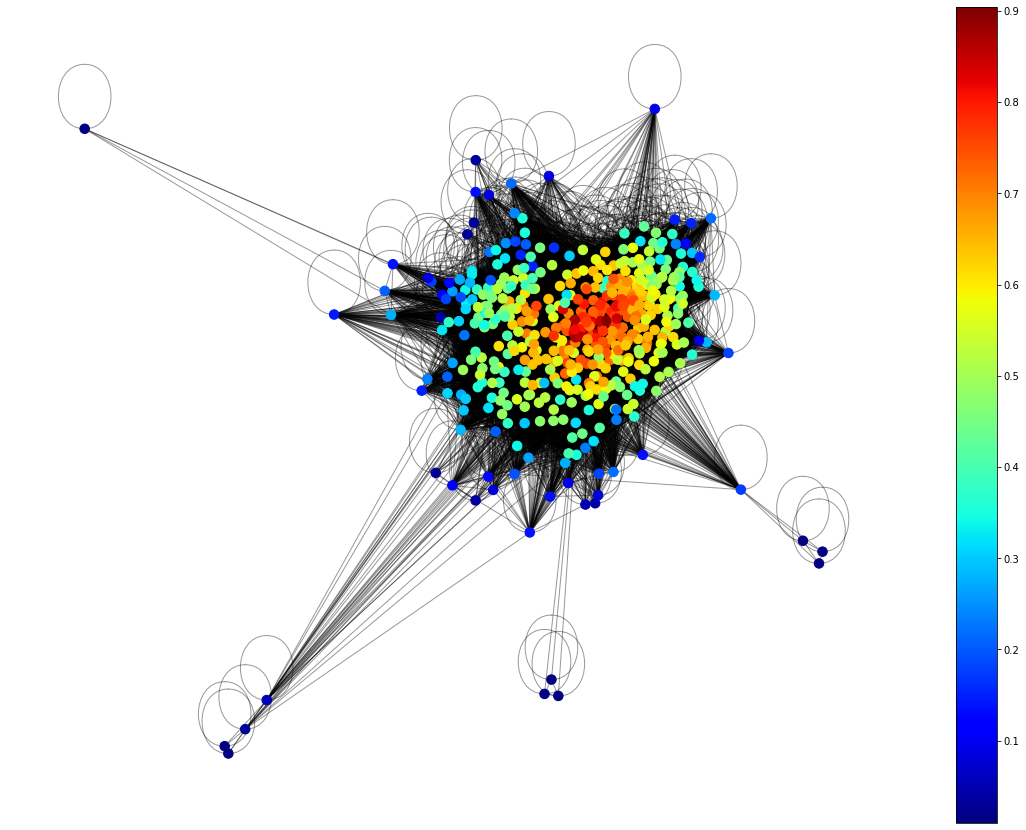

In [ ]:
# the degree centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree_centrality.png', transparent=True,dpi=300)
plt.show()

Perceba que o gráfico é igual ao gráfico de nós comuns, porém com os valores gerados estando entre 0 e 1.

Através do código abaixo foi possível obter a lista dos 10 artistas (nós) com maior grau na rede junto de seus respectivos degree centralities , que são:

In [ ]:
# Pega lista nós e seu respectivo degree_centrality ordenado do maior para o menor
lista_grau_centralidade = [[value,key] for key,value in nx.degree_centrality(subgraph).items()]
lista_grau_centralidade.sort(reverse=True)

# imprime artistas e graus
print("Artista \t     Grau \n")
for grau,artista in lista_grau_centralidade[:10]:
  print ("{:<20} {:<15}".format( artista, grau))

Artista 	     Grau 

Drake                0.9038076152304608
Rihanna              0.8977955911823646
Ed Sheeran           0.8717434869739479
Coldplay             0.8717434869739479
Imagine Dragons      0.8657314629258517
Maroon 5             0.8637274549098196
Justin Bieber        0.8557114228456913
The Chainsmokers     0.8537074148296593
Kanye West           0.8537074148296593
Miley Cyrus          0.843687374749499


#### Resultado 

Observando as figuras e os valores dos principais nós utilizando o degree centrality é possível notar que a rede possui nós que estão conectados com a grande maioria dos outros nós, como por exemplo o nó referente ao artista Drake está conectado a 90% dos nós da rede, o que demonstra a sua grande presença na maioria das playlists.

## Closeness Centrality

A métrica de closeness centrality diz respeito a distância média de um determinado nó para todos os outros nós da rede (Considerando os caminhos mais curtos).

Tal calculo é feito de tal forma que quanto maior o valor, mais perto dos outros nós da rede um nó está e quanto menor o valor, mais distante dos outros ele está. O valor gerado também está entre 0 e 1.

O gráfico gerado da métrica de closeness centrality obtido da nossa rede foi:

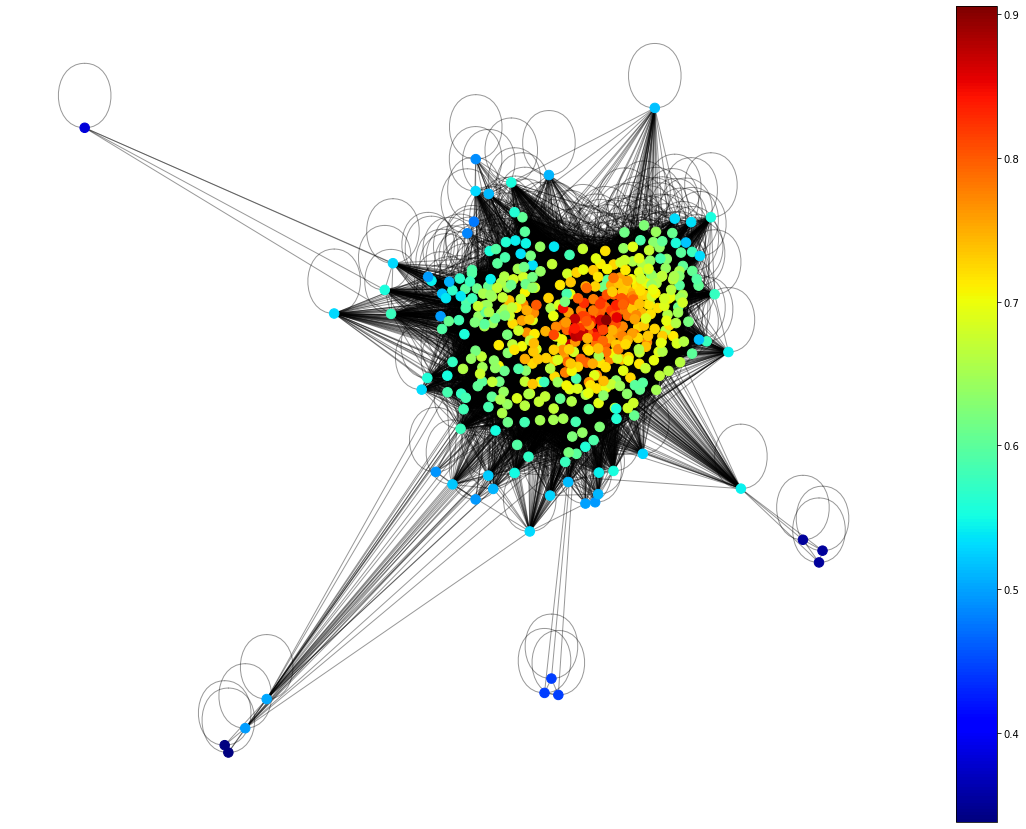

In [ ]:
# the closeness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.closeness_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('closeness_centrality.png', transparent=True,dpi=600)
plt.show()

Observando a figura é possível perceber que a grande maioria dos nós possui a métrica acima de 0.5, e que o centro da figura contém os nós com maior medida, o que indica estarem mais conectados e mais próximos de todos os outros nós.

A lista dos dez nós com maior valor de closeness centrality da rede foi:

In [ ]:
# Pega lista nós e seu respectivo closeness_centrality ordenado do maior para o menor
lista_distacia_centro = [[value,key] for key,value in nx.closeness_centrality(subgraph).items()]
lista_distacia_centro.sort(reverse=True)

# Imprime artistas e métrica
print("Artista \t     Closeness Centrality \n")
for grau,artista in lista_distacia_centro[:10]:
  print ("{:<20} {:<15}".format( artista, grau))

Artista 	     Closeness Centrality 

Drake                0.9056261343012704
Rihanna              0.9007220216606499
Ed Sheeran           0.875438596491228
Coldplay             0.875438596491228
Maroon 5             0.8739054290718039
Justin Bieber        0.8708551483420593
Imagine Dragons      0.8708551483420593
The Chainsmokers     0.8663194444444444
Kanye West           0.8633217993079585
Miley Cyrus          0.8588640275387264


#### Resultado

Observando a figura e os 10 nós principais podemos perceber que, assim como no degree centrality, o closeness centrality aplicado na rede nos mostra que o nível de conexão entre os nós é bem alto, principalmente no centro da figura, onde estão os 10 principais mostrados na lista  anterior com uma pequena alteração nas posições.
 
Essa métrica nos dá uma visão clara de que os artistas (nós) selecionados para compor nosso grafo possuem uma enorme presença na grande maioria das playlists utilizadas como base para os dados.

## Betweenness Centrality

Essa métrica define quais são os nós mais importantes em fazer a ligação entre os outros nós, o grau de participação daquele nó nos menores caminhos de todos os nós entre si. Em outras palavras, o quanto um determinado grau faz parte do fluxo de caminhos ou informações.

A figura abaixo exibe a rede sob a ótica da aplicação do Betweenness centrality:

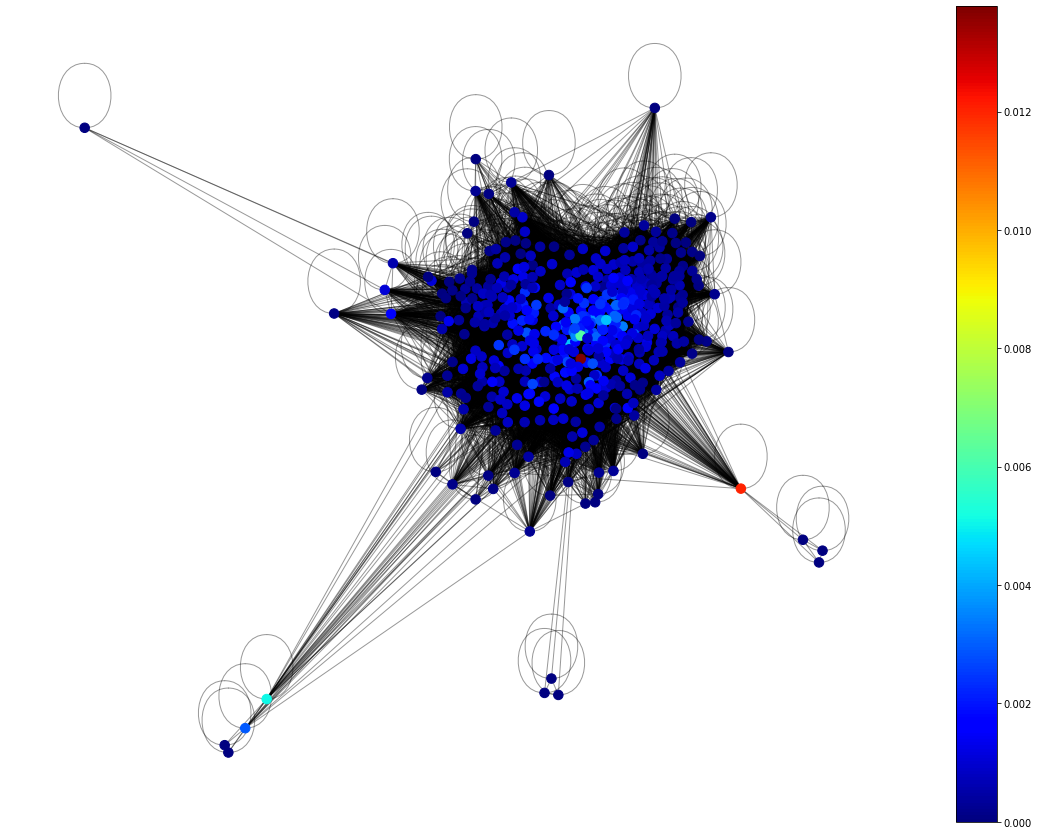

In [ ]:
# the betwenness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.betweenness_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('betweenness_centrality.png', transparent=True,dpi=600)
plt.show()

A figura mostra que para a maioria dos nós a medida do Betweenness Centrality é baixa, pois, como vimos anteriormente, a grande maioria dos nós tem conexões entre si, mas existem sim nós que se destacam nessa métrica.

Abaixo estão exibidos os 10 nós com maior destaque na rede para essa métrica:

In [ ]:
# Pega lista nós e seu respectivo betweenness_centrality ordenado do maior para o menor
lista_entre_nodes = [[value,key] for key,value in nx.betweenness_centrality(subgraph).items()]
lista_entre_nodes.sort(reverse=True)

# Imprime artistas e métrica
print("Artista \t     Grau \n")
for grau,artista in lista_entre_nodes[:10]:
  print ("{:<20} {:<15}".format( artista, grau))

Artista 	     Grau 

One Direction        0.013777209542603941
Stephen Schwartz     0.012012449411208858
Justin Bieber        0.006213204994955751
Kanye West           0.00528134881014589
Titus Andronicus     0.005075014685962369
Drake                0.005074796189196551
Coldplay             0.004352292199738498
Rihanna              0.0043076793160292835
Bruno Mars           0.003701078702896411
Ed Sheeran           0.003609014762029742


#### Resultado
É possível observar muito bem na figura o motivo do destaque dos nós que aparecem nos 10 principais para essa métrica, já que estão muito bem destacados fazendo a ponte entre um grande número de nós, tornando possível o menor caminho entre eles.

Essa medida é importante para verificarmos os nós que fazem a ligação entre artistas da nossa rede.

No nosso  caso, podemos interpretar essa métrica como sendo os  artistas que são ouvidos por pessoas de diferentes gostos musicais, fazendo a ponte entre outros artistas.

## EigenVector Centrality

A métrica Eigenvector centrality (Autovetor) mede a importância de um nó de acordo com a importância dos seus vizinhos. A grosso modo, a ideia é a de que se eu sou "amigo" de alguém importante eu sou importante também.

Abaixo a figura exibindo a rede com a aplicação do EigenVector Centrality:

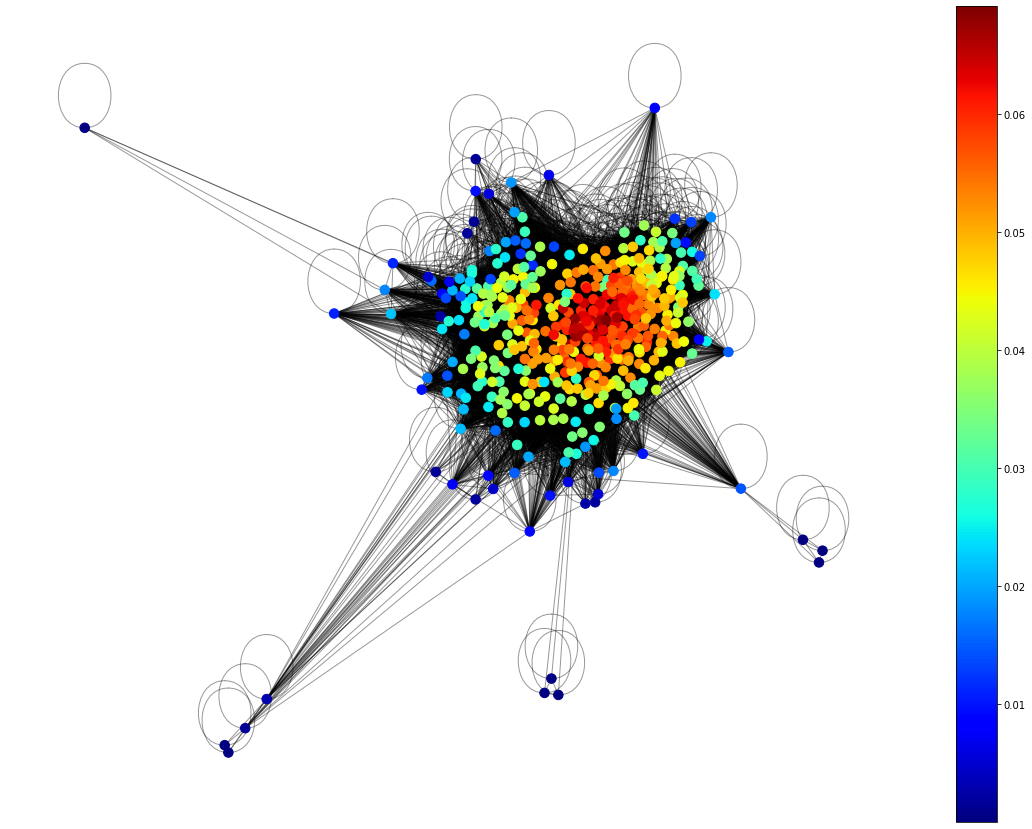

In [ ]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.eigenvector_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eigenvector_centrality.png', transparent=True,dpi=600)
plt.show()

A figura mostra que, como nas métricas anteriores, os nós mais importantes e conectados na rede se encontram no centro. O diferencial dessa métrica é ver quem são os nós que estão conectados a esses nós mais importantes, por isso o centro contém mais nós em destaque do que nas métricas anteriores.

Abaixo estão exibidos os 10 nós com maior destaque na rede para essa métrica.

In [ ]:
# Pega lista nós e seu respectivo betweenness_centrality ordenado do maior para o menor
lista_autovetor = [[value,key] for key,value in nx.eigenvector_centrality(subgraph).items()]
lista_autovetor.sort(reverse=True)

# Imprime artistas e métrica
print("Artista \t     Grau \n")
for grau,artista in lista_autovetor[:10]:
  print ("{:<20} {:<15}".format( artista, grau))

Artista 	     Grau 

Rihanna              0.06915772706515273
Drake                0.06915573788772797
Imagine Dragons      0.06783984963613547
Ed Sheeran           0.06767682755458311
Maroon 5             0.06745936056856662
Miley Cyrus          0.0672458507699604
The Chainsmokers     0.06722648221963617
Coldplay             0.0669937703418811
Justin Bieber        0.06684763711175568
Kanye West           0.0668390678471066


#### Resultado

Como nesse caso a métrica da importância a quem tem os vizinhos mais importantes, podemos ver no top 10 dos nós com maior destaque que o nó relativo a Rihanna, que antes ficou quase sempre em 2º lugar nas outras métricas,  agora foi para o primeiro.

Além disso, alguns dos outros nós também estão em posições diferentes das outras listas, mas são em geral os mesmos que apareceram anteriormente.

Essa métrica é diferente, pois não valoriza a quantidade ou peso de conexões, mas sim a qualidade delas. No caso da nossa rede é possível identificar com o autovetor os artistas que mais aparecem nas playlists juntos dos artistas mais relevantes.

# Análise Bivariada (PDF e CDF)

### PDF - Probability Density Function

A Probability Density Function (PDF) é uma função que possui a capacidade de informar a probabilidade de uma variável assumir um determinado valor.

Aplicamos essa função na rede em relação à métrica degree dos nós para verificarmos a probabilidade de um nó da rede ter um determinado grau.

Abaixo a figura exibindo a rede com a aplicação da PDF em relação ao grau dos nós e o histograma dos graus:

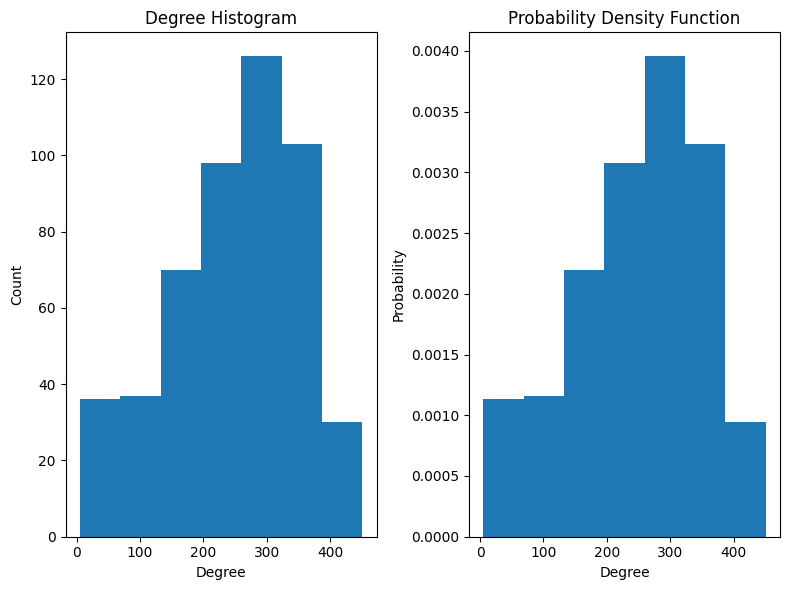

In [ ]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in subgraph.degree()], reverse=True)  

fig, ax = plt.subplots(1,2,figsize=(8,6))

# all_data has information about degree_sequence and the width of each bin
all_data = ax[0].hist(degree_sequence,bins=7)
ax[1].hist(degree_sequence,bins=7,density=True)

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")

ax[1].set_title("Probability Density Function")
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("Degree")

plt.tight_layout()
plt.show()

Para analisar os gráficos é necessário observar os valores do eixo X (referente ao nó, no caso dos dois gráficos) e os do eixo Y (Que no histograma refere-se à quantidade de nós e no PDF a probabilidade de um nó assumir tal valor) e estabelecer uma relação de sentido entre eles.
Observando primeiro o histograma (figura da esquerda), podemos perceber que aproximadamente 120 nós da rede possuem grau 300, pouco mais de 100 vértices têm grau entre 300 e 400 etc.

No caso do PDF, o resultado segue o mesmo padrão, trocando, porém, a quantidade de nós pela probabilidade. Assim, a probabilidade de um nó da rede ter grau 300 é de 40%, de ter grau 100 é de aproximadamente 12% etc.
Ambos os gráficos mostram a predominância do grau 300 nos nós da rede, enfatizando a alta conectividade da amostra de rede analisada.

Abaixo a figura exibindo a rede com a aplicação da PDF em relação ao grau dos nós com a linha KDE:

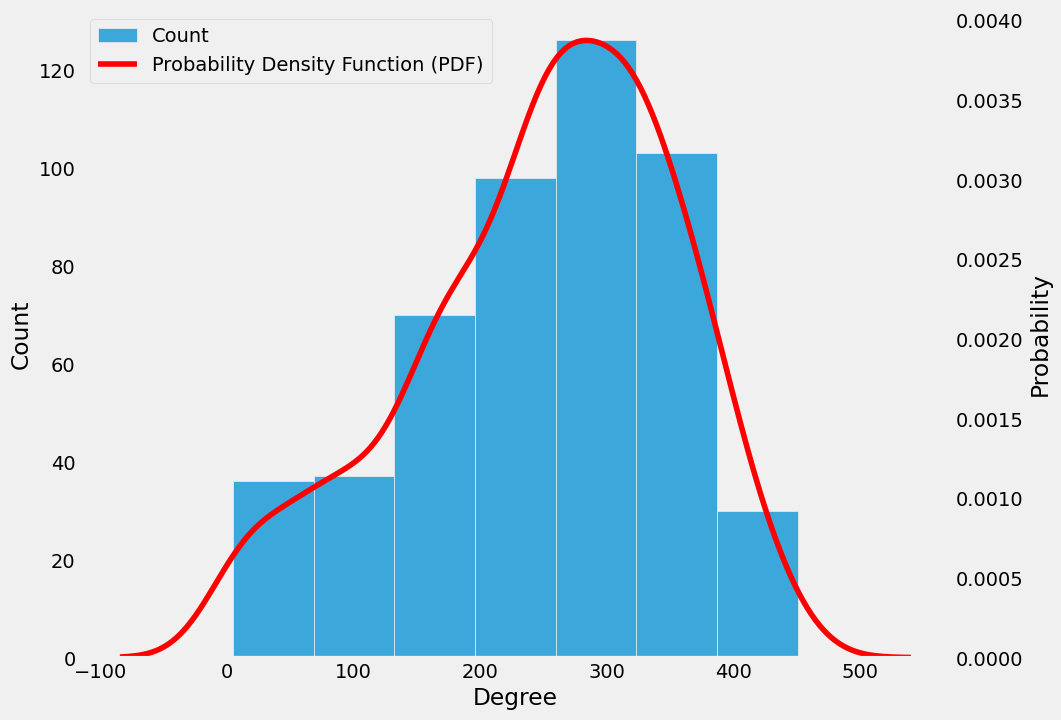

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

Analisando com a linha KDE (Que nos fornece uma precisão maior) podemos observar que a frequência dos graus cresce até chegar ao pico por volta do grau 280, o qual possui também maior probabilidade na PDF, decaindo rapidamente logo após esse valor.

#### Resultado
Como a maior parte dos nós possuem graus por volta do 280, em uma rede com apenas 500 nós, isso mostra novamente que os nós da rede possuem grande numero de conexões entre si.

### CDF - Cumulative Density Function

A função Cumulative Density Function tem a capacidade de definir a probabilidade de um dado valor estar em um determinado intervalo acumulado.

Abaixo a figura exibindo a rede com a aplicação da CDF levando em consideração o grau dos nós.

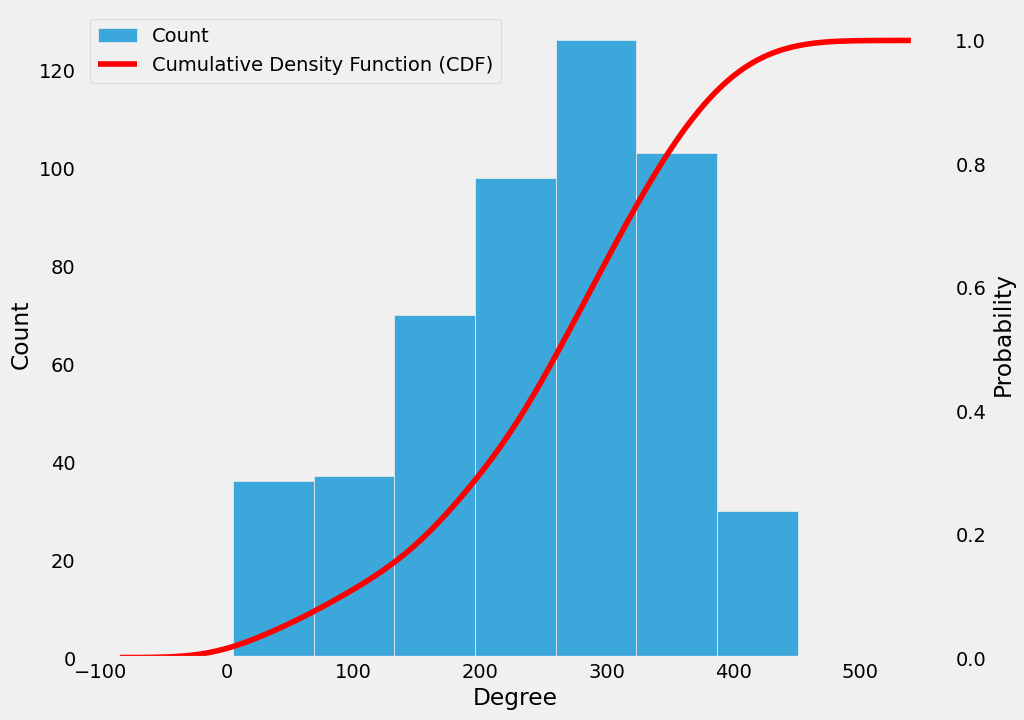

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

A leitura do CDF é realizada de maneira parecida com a do PDF explicada anteriormente, porém com um significado um pouco diferente.
 
Por exemplo, analisando o grafo podemos perceber (olhando pro eixo X e eixo Y) que 60% (0.6) dos nós da rede possuem um grau menor ou igual a 300. Analogamente, lendo o gráfico podemos ver que 20% dos vértices possuem grau 200 ou menor e dessa forma a leitura pode ser estendida para os demais graus e probabilidades.

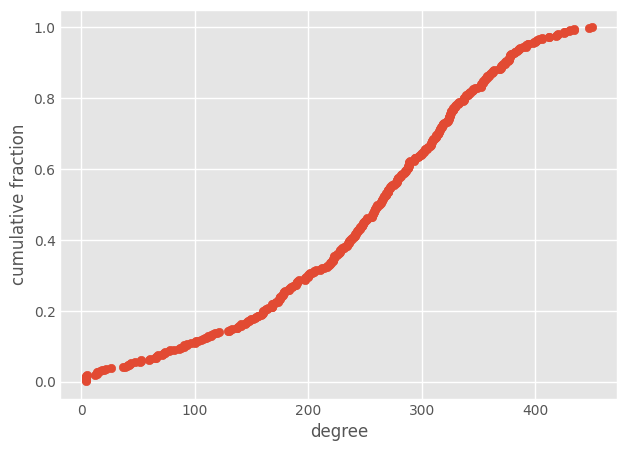

In [ ]:
plt.style.use("ggplot")

# Another way to visualize the cumulative distribution
def ecdf(data):
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)

def ecdf_degree(G):
    """ECDF of degree."""
    num_neighbors = [len(list(G.neighbors(n))) for n in G.nodes()]
    x, y = ecdf(num_neighbors)
    plt.scatter(x, y)
    plt.xlabel("degree")
    plt.ylabel("cumulative fraction")

ecdf_degree(subgraph)

A figura acima apresenta os mesmos dados apenas de uma forma diferente, sendo possível identificar melhor os valores.

#### Resultado 


Utilizando a função CDF foi possível identificar quais os intervalos de graus possuem o maior número de nós no grafo, confirmando novamente de forma mais precisa a interpretação obtida da função PDF, e perceber que a maioria dos nós possuem graus por volta de 280, onde a curva do CDF é mais acentuada.

# Análise Multivariada

A análise multivariada consiste em uma correlação entre as métricas de Node Ranking com o objetivo de analisar como e se elas são afetadas uma pelas outras. Por exemplo, qual a relação entre o degree centrality e o closeness centrality? O que acontece com um quando o outro aumenta? O seguinte gráfico nos ajuda nessa análise:

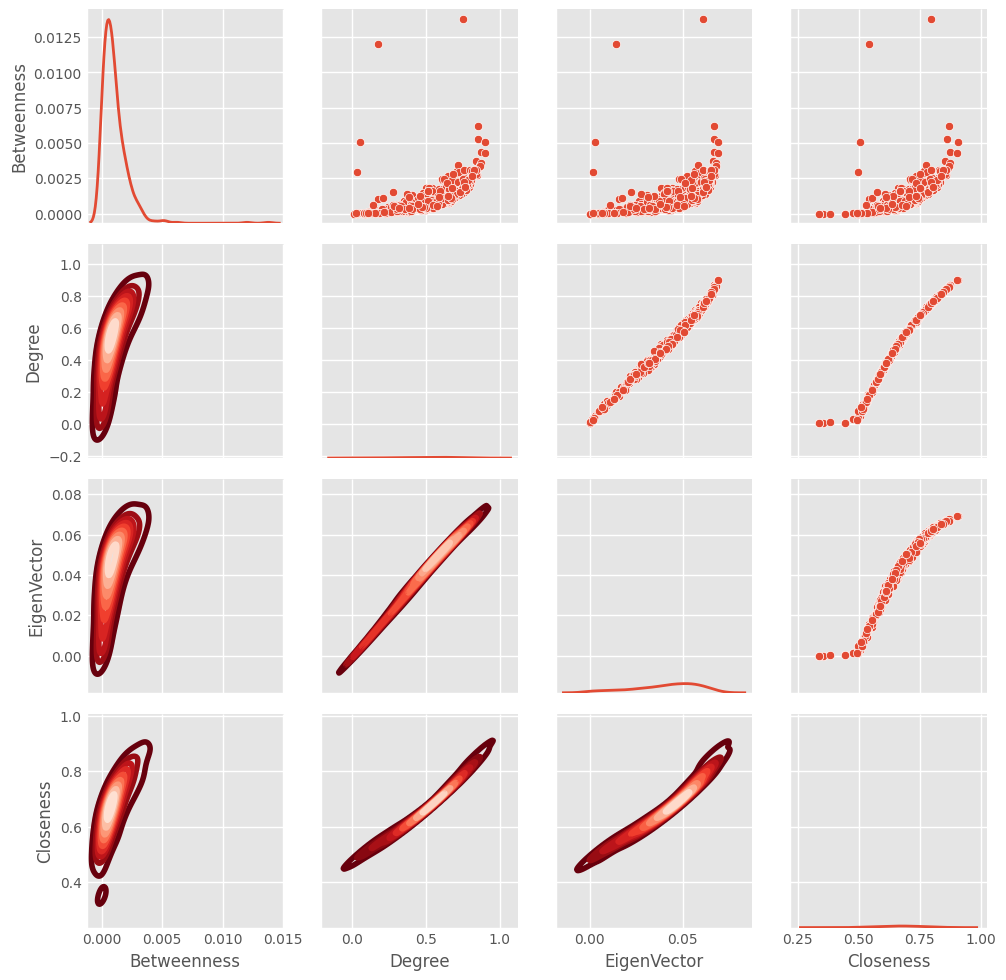

In [ ]:
bc = pd.Series(nx.betweenness_centrality(subgraph))
dc = pd.Series(nx.degree_centrality(subgraph))
ec = pd.Series(nx.eigenvector_centrality(subgraph))
cc = pd.Series(nx.closeness_centrality(subgraph))

df = pd.DataFrame.from_dict({"Betweenness": bc,
                            "Degree": dc,
                            "EigenVector": ec,
                            "Closeness": cc})
df.reset_index(inplace=True,drop=True)

fig = sns.PairGrid(df)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
plt.show()

Perceba que o gráfico se apresenta como uma matriz 4x4 de gráficos menores. Dessa forma, por exemplo, o elemento 3x2 corresponde ao gráfico que relaciona o eigenVector (No eixo Y) com o degree (No eixo X).

Observando a figura é possível identificar que a relação das métricas ocorre sempre de forma crescente, algumas mais acentuadas e outras menos, e com variações na curva de crescimento, mas todas possuem uma boa correlação.

#### Resultado
Mesmo as grandezas medindo diferentes aspectos da rede como um todo é possível sim notar uma correlação entre elas, mostrando que quando uma delas aumenta a outra também tende a aumentar.

# Análise de decomposição da rede

A análise de decomposição da rede consiste em decompor a rede em camadas denominadas cores. Cada camada da rede leva em consideração o grau dos nós. Por exemplo, a camada 1-core refere-se ao conjunto de nós das redes cujo grau é no mínimo 1. O 2-core os nós que possuem grau 2 ou maior, 3-core os que possuem grau 3 ou mais etc. O último core de uma rede é denominado núcleo dessa rede.

Além do core, outra ideia utilizada na análise de decomposição é a do shell. O shell faz referência à camada que foi retirada para alcançar um determinado core. Por exemplo, para alcançar a camada 2-core os nós da rede cujo grau é igual a 1 precisou ser retirada, a essa camada retirada dá-se o nome de 1-shell. Assim, para alcançar a camada 3-core precisa-se tirar o 2 shell e assim por diante.

Vale lembrar que essas camadas não precisam necessariamente serem incrementadas de um em um,isto é, pode ser que exista uma rede cujas camadas são: 1-core, 3-core e 4-core. Perceba que nesse exemplo não existe o 2-core, o que é totalmente possível (É como se nessa rede não existissem nós de grau 2).

O trecho de código abaixo nos fornece algumas informações gerais sobre as camadas da rede.

In [ ]:
subgraph.remove_edges_from(nx.selfloop_edges(subgraph))

core_numbers = nx.core_number(subgraph).items()
# Imprime o número dos cores da rede
print("Camadas de decomposição:")
print(set([v for k,v in core_numbers]))
print("\nQuantidade de camadas:",len(set([v for k,v in core_numbers])))


# Imprime o número do último core
print("\nÚltima camada de decomposição, core final da rede:",list(set([v for k,v in core_numbers]))[-1])


Camadas de decomposição:
{3, 4, 11, 13, 15, 17, 19, 20, 22, 34, 37, 38, 40, 41, 45, 48, 49, 51, 58, 59, 61, 62, 63, 64, 66, 69, 70, 71, 73, 74, 77, 80, 82, 84, 85, 86, 88, 90, 94, 95, 97, 98, 101, 102, 105, 107, 109, 112, 113, 117, 122, 124, 125, 128, 129, 130, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 146, 147, 148, 151, 152, 153, 155, 156, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 179, 181, 182, 184, 186, 187}

Quantidade de camadas: 97

Última camada de decomposição, core final da rede: 187


Relembremos a figura exibindo a rede colorida com base nos graus dos nós:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


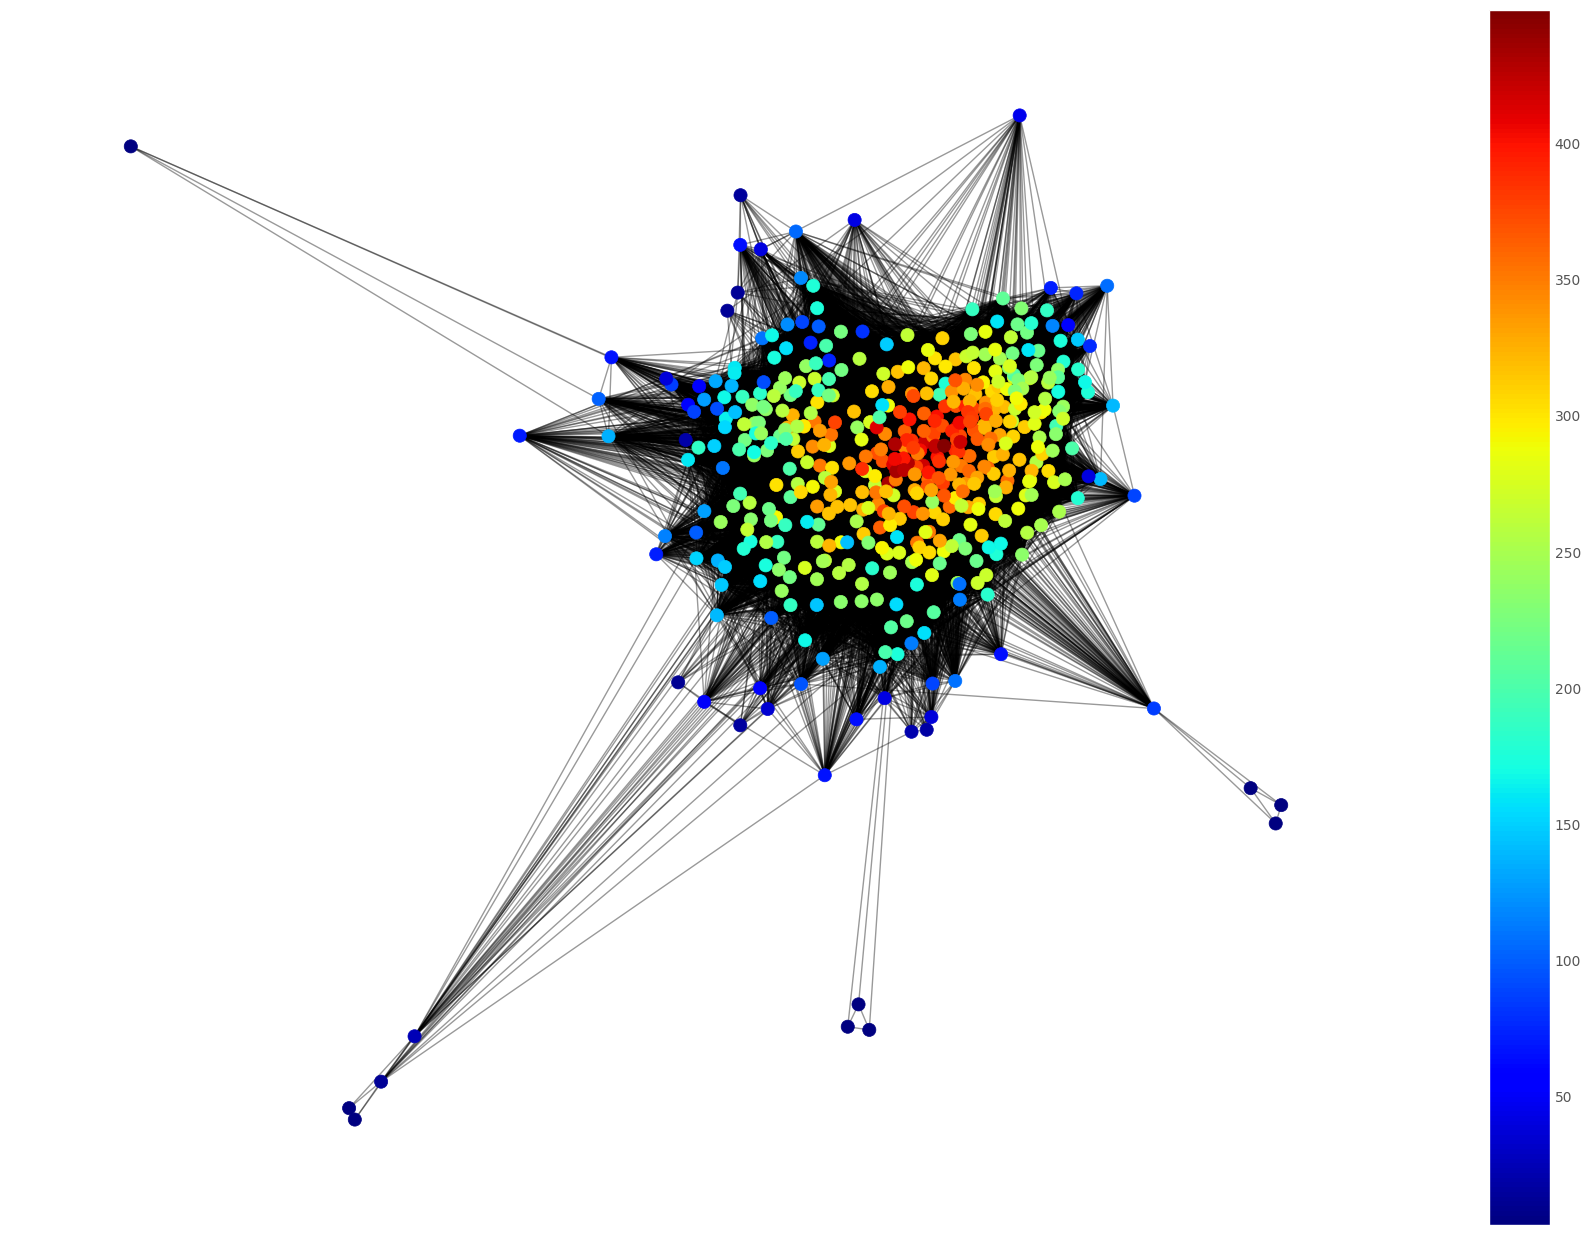

In [ ]:
# the degree of network(subgraph)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('sociopatterns.png', transparent=True,dpi=600)
plt.show()

Perceba que os nós de menor grau estão mais longe do centro da rede, e os de maior grau se localizam mais no centro. Uma decomposição realizada nessa rede começaria pelos nós com menor grau (da periferia) até chegar no núcleo da rede (os nós do centro).

O gráfico abaixo mostra o núcleo da rede junto da camada anterior a esse núcleo que foi retirada (Nesse caso a 186-shell) coloridas de vermelho e azul, respectivamente.

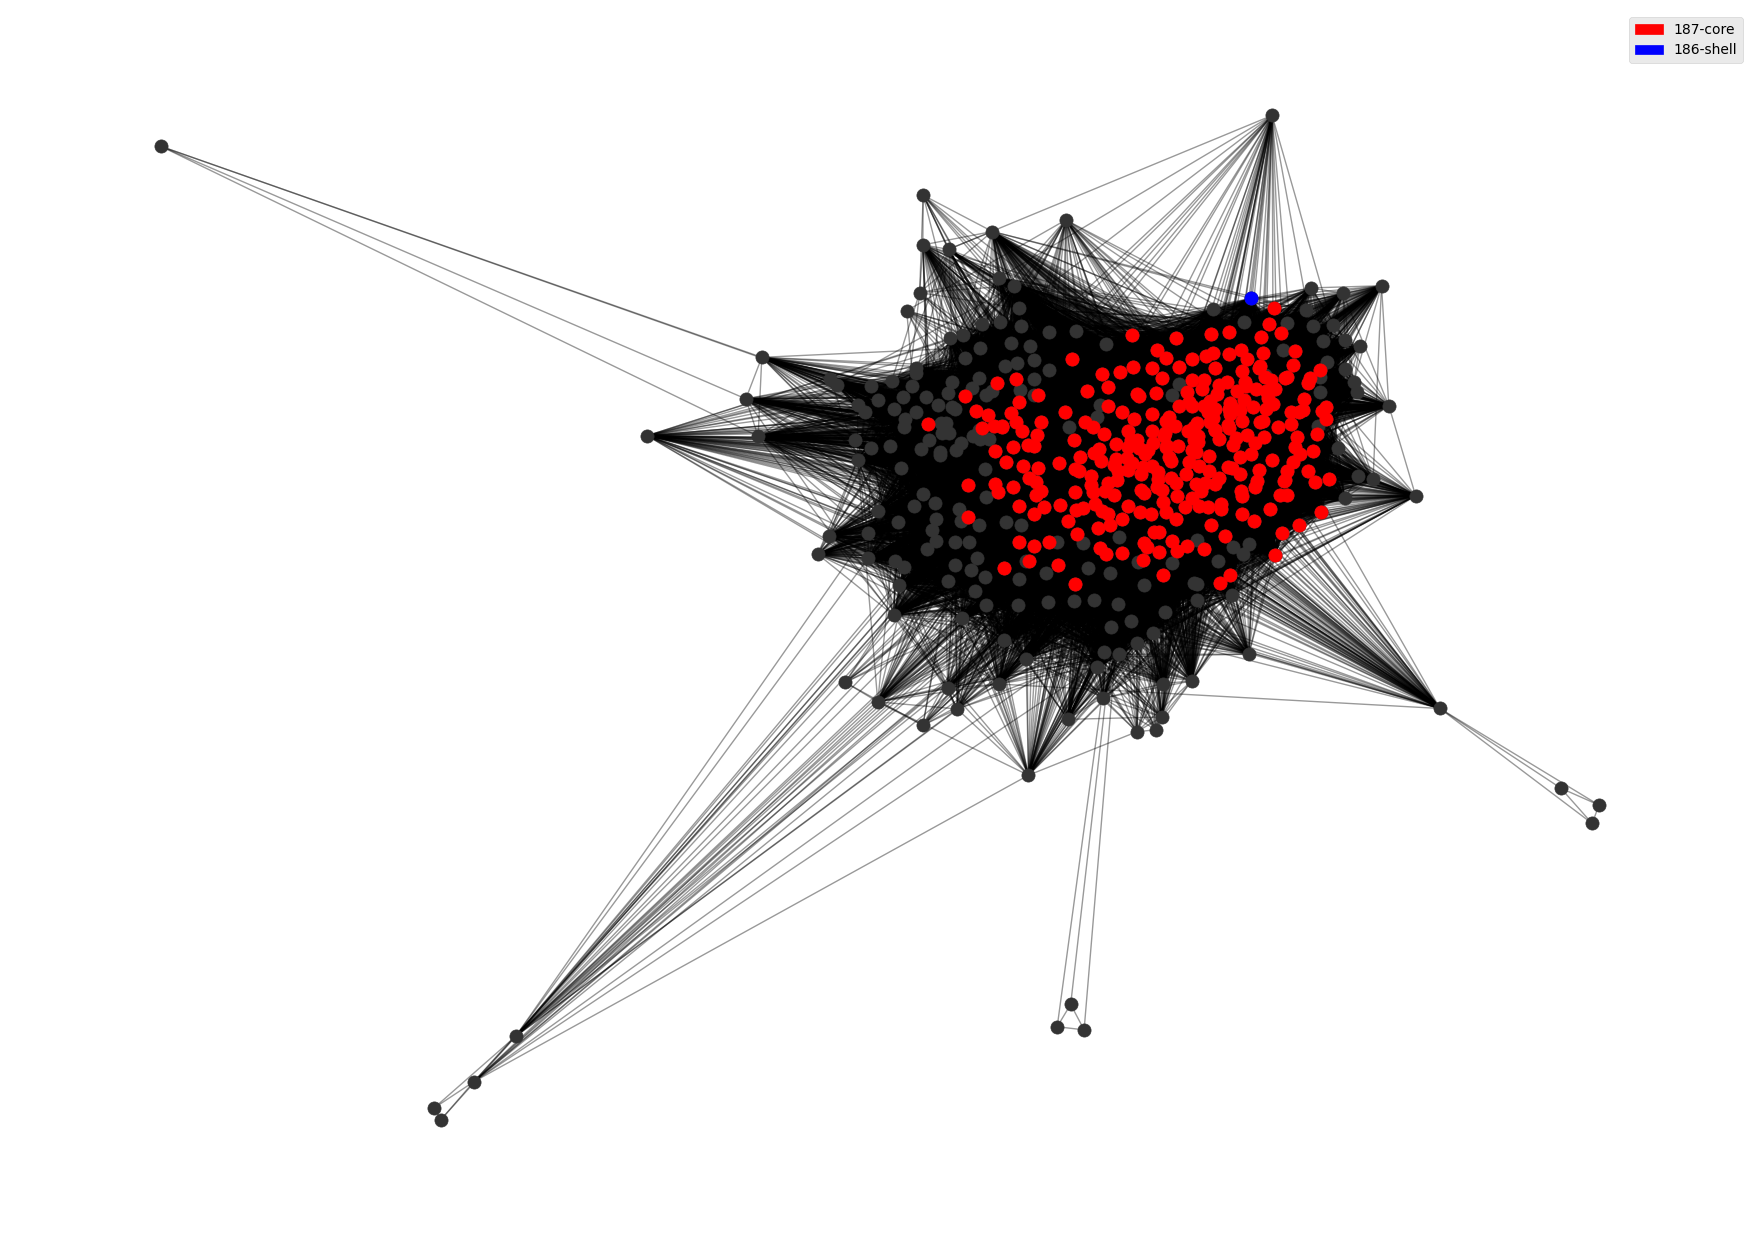

In [ ]:
subgraph.remove_edges_from(nx.selfloop_edges(subgraph))
# Cores mais profundos
shell_186 = nx.k_shell(subgraph, 186)
core_187 = nx.k_core(subgraph, 187)

# the degree of network(subgraph)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color="#333333",node_size = 90)

# draw nodes
nodes = nx.draw_networkx_nodes(shell_186,
                 pos=pos,
                 node_color="blue",node_size = 90)

nodes = nx.draw_networkx_nodes(core_187,
                 pos=pos,
                 node_color="red",node_size = 90)

# static legend
red_patch = mpatches.Patch(color='red', label='187-core')
blue_patch = mpatches.Patch(color='blue', label='186-shell')
plt.legend(handles=[red_patch,blue_patch])

plt.axis("off")
plt.savefig('k-core_sociopatterns.png', transparent=True,dpi=600)
plt.show()

A figura evidencia que realmente os nós remanescentes até o último core são os que possuem um maior grau, conforme vistos na figura anterior, e que do penúltimo para o último core apenas um nó foi removido, que está na figura em azul, representando a shell do último core.

O trecho de código abaixo imprime alguns dos nós que compõem o último core e o nó específico que saiu do penúltimo para o último core.

In [ ]:
# Imprime quem faz parte do core mais profundo
print("187 Core:")

core = 187
contador = 0
imprimir = 20
for i in nx.k_core(subgraph,core):
  print(i+", ",end="")
  contador +=1
  if(contador == imprimir):
    print("...")
    break

# Imprime quem faz parte do shell mais profundo
print("\n186 Shell:")

shell = 186
contador = 0
for i in nx.k_shell(subgraph,shell):
  print(i)
  contador +=1


187 Core:
blink-182, A$AP Rocky, Alesso, Chance The Rapper, Miley Cyrus, Eminem, Halsey, Fall Out Boy, Avicii, Lil Yachty, Vance Joy, Gym Class Heroes, Backstreet Boys, Hunter Hayes, John Mayer, Lorde, Alessia Cara, T-Pain, A$AP Ferg, Kiiara, ...

186 Shell:
Don Omar


#### Resultado
Os dados obtivos mostram que a decomposição da rede consegue obter os nós que tem maior grau, retirando camada por camada e realizando uma espécie de filtragem, de forma que também é possível observar a cada passo quais os nós estão saindo.

#Conclusão

Avaliando todos os resultados do nosso estudo podemos constatar algumas informações gerais sobre a rede (Que são congruentes com a forma como nós construímos o grafo) com resultados interessantes e compatíveis com o nível de fama dos artistas que aparecem com valores mais expressivos durante o cálculo das nossas métricas.

Pelo fato de usarmos os 500 artistas com maior grau, levando em consideração o peso das conexões dos nós, nossa rede ficou apenas com os artistas que mais aparecem juntos nas playlists.

Tal filtragem fez com que os nós, principalmente os mais centrais, possuíssem conexões com a grande maioria dos outros nós, o que nos mostrou resultados interessantes durante a aplicação das métricas de Node Ranking, em que em sua maioria os artistas mais destacados se repetiam entre uma métrica e outra.

O código abaixo imprime algumas informações sobre os artistas que mais apareceram nos destaques das métricas de ranqueamento de nós.

In [ ]:
# Imprime artistas

df_artistas_geral = pd.DataFrame()
lista_geral = [artista for grau,artista in lista_grau_centralidade[0:10]+lista_distacia_centro[0:10]+lista_entre_nodes[0:10]+lista_autovetor[0:10]]
df_artistas_geral["artistas"] = lista_geral

print("Artista              Aparições              Grau      Porcentagem de conectividade           Peso do Nó")
for artista,count in df_artistas_geral.artistas.value_counts().items():
  print ("{:<20} {:<15} {:=10} {:=10} {:=40}  ".format(artista,count ,subgraph.degree[artista], (subgraph.degree[artista]/500)*100,lista_pesos[lista_artistas.index(artista)][0]) )


Artista              Aparições              Grau      Porcentagem de conectividade           Peso do Nó
Drake                4                      449       89.8                                   255724  
Rihanna              4                      446       89.2                                    75456  
Ed Sheeran           4                      433       86.6                                    56572  
Coldplay             4                      433       86.6                                    30902  
Justin Bieber        4                      425       85.0                                    52264  
Kanye West           4                      424       84.8                                    96390  
Imagine Dragons      3                      430       86.0                                    30434  
Maroon 5             3                      429       85.8                                    40446  
The Chainsmokers     3                      424       84.8                      

Podemos ver que os artistas que mais se repetem entre as medidas são, no geral, artistas mundialmente conhecidos atualmente, mesmo tendo sido utilizado apenas uma fração do dataset original para a realização da análise.

Um aspecto interessante proveniente da característica de coocorrência da rede que pode ser observado no nó referente ao artista Drake é que, mesmo tendo um grau bem próximo ao de outros nós importantes como o da Rihanna, o peso de suas conexões se destacou em relação aos outros artistas.

Levando em consideração o contexto da rede, isso se deve ao fato de que, pela análise, provavelmente o Drake tenha se repetido mais vezes em cada playlist (Através de várias músicas diferentes) do que os demais artistas da amostra.

Este estudo se mostra  interessante também para percebermos como é possível utilizar o tratamento dos dados do nosso cotidiano para entender aspectos mais difíceis de serem compreendidos apenas ao observar sem uma devida filtragem. Além disso, mostra o quão útil é transformar um contexto real em contextos de redes para analisar algumas características interessantes.

A figura abaixo (Gerada por meio da ferramenta Gephi) permite a visualização da rede completa, com o nome dos artistas de maior grau, analisada nesse estudo:


![img](https://miro.medium.com/max/700/1*uqJCNv-QM3yct3HXhUlDLA.png)


Deploy da rede interativa:

https://carlos1999.github.io/Network_Analysis_Spotify_Playlists/network/